In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tsfm_public.models.tspulse.modeling_tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.ad_helpers import AnomalyScoreMethods
from tsfm_public.toolkit.time_series_anomaly_detection_pipeline import TimeSeriesAnomalyDetectionPipeline

# Example Datafile

Data instance from IOPS dataset ([Paper](https://arxiv.org/html/2402.10802v1)). The data example is a part of the IOPS dataset.

The IOPS data set is an anonymized dataset with performance indicators that reflect the scale, quality of web services, and health status of a machine.



In [2]:
data_path = "https://huggingface.co/datasets/AutonLab/Timeseries-PILE/resolve/main/anomaly_detection/TSB-UAD-Public/IOPS/KPI-4d2af31a-9916-3d9f-8a8e-8a268a48c095.test.out"


## Helper Functions for Data Loading and Processing

`load_data` loads the large dataset in chunks.

`attach_timestamp_column` current pipeline expects a timestamp column in the input. The IOPS dataset does not have an explicit time column specified. This helper function attach a dummy timestamp column to the dataset.



In [3]:
def load_data(file_path: str, max_length: int, min_length: int):
    data = []
    extra_args = {}
    if file_path.endswith("gz"):
        extra_args["compression"] = "gzip"
    for chunk in pd.read_csv(file_path, header=None, sep=",", chunksize=max_length, *extra_args):
        if (chunk is None) or (chunk.ndim != 2):
            break
        chunk.columns = ["x", "y"]
        chunk["x"] = chunk.x.interpolate(method="cubic").ffill().bfill()
        chunk["y"] = chunk.y.ffill().bfill()
        if chunk.shape[0] > min_length:
            data.append(chunk)
        elif len(data) > 0:
            data[-1] = pd.concat([data[-1], chunk], axis=0)
    return data


def attach_timestamp_column(
    df: pd.DataFrame, time_col: str = "timestamp", freq: str = "D", start_date: str = "2022-01-01"
):
    n = df.shape[0]
    if time_col not in df:
        df[time_col] = pd.date_range(start_date, freq=freq, periods=n)
    return df

In [4]:
max_length, min_length = 5_000, 2_000

data = load_data(data_path, max_length, min_length)

## Loading ZeroShort TSPulseReconstruction Model

In [5]:
path_to_tspulse_model = "PATH TO TSPULSE MODEL"
zeroshot_model = TSPulseForReconstruction.from_pretrained(
    path_to_tspulse_model,
    num_input_channels=1,
    mask_type="user",
)

## Instantiating pipeline

In [6]:
pipeline = TimeSeriesAnomalyDetectionPipeline(
    zeroshot_model,
    timestamp_column="timestamp",
    target_columns=["x"],
    prediction_mode="+".join(
        [
            AnomalyScoreMethods.PREDICTIVE.value,
            AnomalyScoreMethods.TIME_IMPUTATION.value,
            AnomalyScoreMethods.FREQUENCY_IMPUTATION.value,
        ]
    ),
    aggregation_length=64,
    aggr_function="max",
    smoothing_length=16,
    least_significant_scale=0.01,
    least_significant_score=0.1,
)

Device set to use mps:0


In [7]:
df_input = attach_timestamp_column(data[10], time_col="timestamp", freq="s")
df_input.head()

,x,y,timestamp
50000,5.00,0,2022-01-01 00:00:00
50001,4.80,0,2022-01-01 00:00:01
50002,5.25,0,2022-01-01 00:00:02
50003,4.95,0,2022-01-01 00:00:03
50004,5.05,0,2022-01-01 00:00:04


## Computing Anomaly Score With Anomaly Pipeline 

In [8]:
%time
result = pipeline(df_input, batch_size=256, predictive_score_smoothing=True)

CPU times: user 4 μs, sys: 1e+03 ns, total: 5 μs
Wall time: 8.34 μs


/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Plotting the score vs TRUE Anomaly Marks

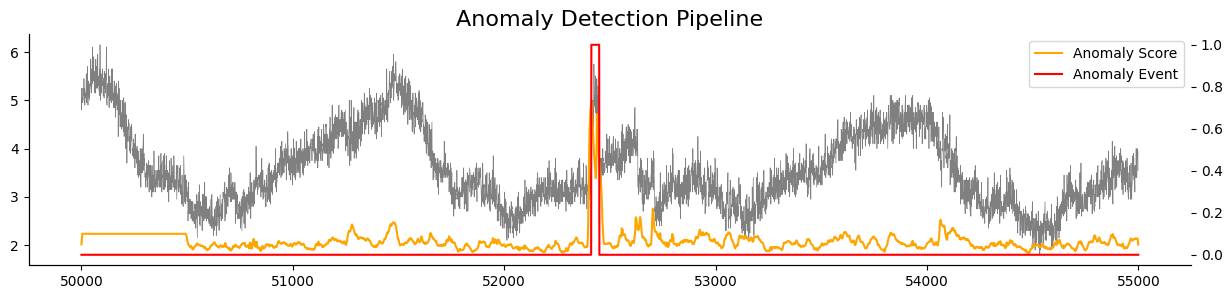

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax2 = ax.twinx()
result.x.plot(ax=ax, color="gray", linewidth=0.5)
result.anomaly_score.plot(ax=ax2, color="orange", label="Anomaly Score")
result.y.plot(ax=ax2, color="red", label="Anomaly Event")
ax2.legend()
# ax2.set_yticks([])
ax.set_title("Anomaly Detection Pipeline", fontsize=16)
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

Anomlay result attaches anomaly scores as a new column. By default the scores are scaled between (0-1)

In [10]:
result.head(5)

,x,y,timestamp,anomaly_score
50000,5.00,0,2022-01-01 00:00:00,0.049969
50001,4.80,0,2022-01-01 00:00:01,0.062462
50002,5.25,0,2022-01-01 00:00:02,0.074954
50003,4.95,0,2022-01-01 00:00:03,0.087446
50004,5.05,0,2022-01-01 00:00:04,0.099939


## Threshold Based Anomaly Marking

In [11]:
anomaly_threshold = 0.6
result["detections"] = (result["anomaly_score"] > anomaly_threshold).astype(float)

result.head()

,x,y,timestamp,anomaly_score,detections
50000,5.00,0,2022-01-01 00:00:00,0.049969,0.0
50001,4.80,0,2022-01-01 00:00:01,0.062462,0.0
50002,5.25,0,2022-01-01 00:00:02,0.074954,0.0
50003,4.95,0,2022-01-01 00:00:03,0.087446,0.0
50004,5.05,0,2022-01-01 00:00:04,0.099939,0.0


## Computing F1 Score for detection

In [12]:
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score


matrix = confusion_matrix(result["y"].values, result["detections"].values)
matrix = pd.DataFrame(
    matrix,
    columns=["Predicted Anomaly: No", "Predicted Anomaly: Yes"],
    index=["True Anomaly: No", "True Anomaly: Yes"],
)

f_score = f1_score(result["y"].values, result["detections"].values, average="binary")

display(f"F1 score: {f_score:.2f}")
display(matrix)

'F1 score: 0.47'

,Predicted Anomaly: No,Predicted Anomaly: Yes
True Anomaly: No,4954,8
True Anomaly: Yes,24,14


## TSPulse supports multiple prediction modes

In [13]:
prediction_modes = [
    AnomalyScoreMethods.PREDICTIVE.value,
    AnomalyScoreMethods.TIME_IMPUTATION.value,
    AnomalyScoreMethods.FREQUENCY_IMPUTATION.value,
]

prediction_modes.append("+".join(prediction_modes))

display(f"All Prediction Modes: {prediction_modes}")

"All Prediction Modes: ['forecast', 'time', 'fft', 'forecast+time+fft']"

## Mode Triangulation

With an available test data, it is possible to identify best prediction mode for anomaly detection in a given dataset.

In [14]:
f_scores = []

for mode in prediction_modes:
    pipeline = TimeSeriesAnomalyDetectionPipeline(
        zeroshot_model,
        timestamp_column="timestamp",
        target_columns=["x"],
        prediction_mode=mode,
        aggr_win_size=64,
        aggr_function="max",
        smoothing_window_size=16,
        least_significant_scale=0.01,
        least_significant_score=0.1,
    )
    result = pipeline(df_input, batch_size=256, predictive_score_smoothing=True)
    result["detections"] = (result["anomaly_score"] > anomaly_threshold).astype(float)
    f_score = f1_score(result["y"].values, result["detections"].values, average="binary")
    f_scores.append(f_score)

Device set to use mps:0
/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self

Best mode selection is metric or KPI driven. Here we use F1 Score for mode selection

In [15]:
selected_mode = prediction_modes[np.argmax(f_scores)]

print(f"Best Prediction mode for train set: {selected_mode}")

Best Prediction mode for train set: fft


## Test Dataset

In [16]:
df_test = attach_timestamp_column(data[15], time_col="timestamp", freq="s")
df_test.head()

,x,y,timestamp
75000,5.05,0,2022-01-01 00:00:00
75001,5.10,0,2022-01-01 00:00:01
75002,4.95,0,2022-01-01 00:00:02
75003,5.65,0,2022-01-01 00:00:03
75004,5.05,0,2022-01-01 00:00:04


## Executing pipeline With Best Prediction Mode

In [17]:
best_pipeline = TimeSeriesAnomalyDetectionPipeline(
    zeroshot_model,
    timestamp_column="timestamp",
    target_columns=["x"],
    prediction_mode=selected_mode,
    aggr_win_size=64,
    aggr_function="max",
    smoothing_window_size=16,
    least_significant_scale=0.01,
    least_significant_score=0.1,
)

Device set to use mps:0


In [18]:
%time
result_test = pipeline(df_test, batch_size=256, predictive_score_smoothing=True)

CPU times: user 6 μs, sys: 2 μs, total: 8 μs
Wall time: 13.8 μs


/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([128, 1, 1])) that is different to the input size (torch.Size([128, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/sumanta/miniforge3/envs/tsad/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [19]:
result_test.head()

,x,y,timestamp,anomaly_score
75000,5.05,0,2022-01-01 00:00:00,0.030076
75001,5.10,0,2022-01-01 00:00:01,0.033836
75002,4.95,0,2022-01-01 00:00:02,0.037596
75003,5.65,0,2022-01-01 00:00:03,0.041355
75004,5.05,0,2022-01-01 00:00:04,0.045115


## Plotting Scores For Test Data Split

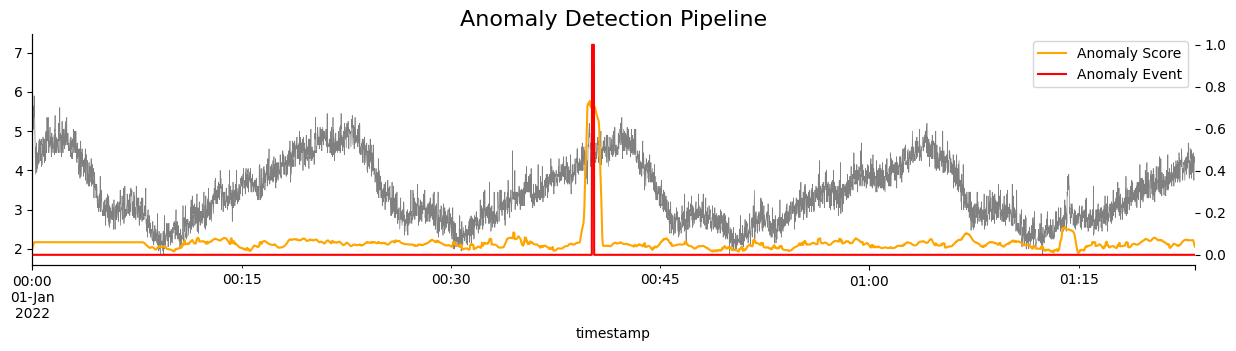

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax2 = ax.twinx()
result_test.set_index("timestamp").x.plot(ax=ax, color="gray", linewidth=0.5)
result_test.set_index("timestamp").anomaly_score.plot(ax=ax2, color="orange", label="Anomaly Score")
result_test.set_index("timestamp").y.plot(ax=ax2, color="red", label="Anomaly Event")
ax2.legend()
# ax2.set_yticks([])
ax.set_title("Anomaly Detection Pipeline", fontsize=16)
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)